<a href="https://colab.research.google.com/github/VIKAS-PURBIA/Vaccination-Data-Analysis-and-Visualization/blob/main/Vaccination_Data_Analysis_and_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name** - Vaccination Data Analysis and Visualization

# **Project Type** -

1. Data Warehousing
2. Data Analysis
3. Exploratory Data Analysis (EDA)

**Contribution**- Individual

**Name**- Vikas Purbia

#**Project Summary** -

This project focuses on building a data warehouse and analytics solution to explore global vaccination coverage, disease incidence trends, and regional disparities.

 **Objectives**

1. Extract, clean, and transform vaccination and disease data from multiple sources.

2. Design a star schema database (fact and dimension tables) in SQLite to ensure normalized storage and referential integrity.

3. Perform Exploratory Data Analysis (EDA) to identify vaccination patterns, disease reduction trends, and regional disparities.

4. Build interactive dashboards in Power BI to provide actionable insights for policymakers and public health monitoring.

#**GitHub Link** -


#**Problem Statement**

Analyze global vaccination data to understand trends in vaccination coverage, disease incidence, and effectiveness. Data will be cleaned, and stored in a SQL database. Power BI will be used to connect to the SQL database and create interactive dashboards that provide insights on vaccination strategies and their impact on disease control

# Dataset

●	Dataset: [1. coverage data](https://docs.google.com/spreadsheets/d/15WOXUmRRzieQao1TMFHDswybS-7KHZb6/edit?usp=drive_link&ouid=109878841429873939556&rtpof=true&sd=true)  
●	Dataset: [2. Incidence Rate](https://docs.google.com/spreadsheets/d/11QnGUPvwYisIgsbnA1283ar2eJDzZx9f/edit?usp=drive_link&ouid=109878841429873939556&rtpof=true&sd=true)  
●	Dataset: [3. Reported cases](https://docs.google.com/spreadsheets/d/1PoFOkfQaIX2aCnazACSK7Yh1wT1ldWMk/edit?usp=sharing&ouid=109878841429873939556&rtpof=true&sd=true)  
●	Dataset: [4. Vaccine Introduction](https://docs.google.com/spreadsheets/d/1G2oPfHtKLHcQXPtf6RSJwSJ8MEBvwFhj/edit?usp=sharing&ouid=109878841429873939556&rtpof=true&sd=true)  
●	Dataset: [5.  Vaccine Schedule Data](https://docs.google.com/spreadsheets/d/1MxxqTIjeTPQ0uNWVp50PfyJK_d5zaZTc/edit?usp=drive_link&ouid=109878841429873939556&rtpof=true&sd=true)  

#**Let's Begin** !

## Import libraries

In [ ]:
# data_pipeline.py
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text

# ---- file paths (update if needed) ----
COVERAGE_FP = 'coverage-data.xlsx'
INCIDENCE_FP = 'incidence-rate-data.xlsx'
CASES_FP = 'reported-cases-data.xlsx'
INTRO_FP = 'vaccine-introduction-data.xlsx'
SCHEDULE_FP = 'vaccine-schedule-data.xlsx'
OUT_DIR = '/mnt/data/cleaned'
os.makedirs(OUT_DIR, exist_ok=True)

# ---- helper functions ----
def clean_columns(df):
    df = df.copy()
    df.columns = (df.columns.str.strip()
                   .str.lower()
                   .str.replace(' ', '_')
                   .str.replace(r'[^0-9a-z_]', '', regex=True))
    return df


def safe_int(series):
    # Keep decimals if present, else convert cleanly to Int64
    s = pd.to_numeric(series, errors='coerce')
    # check if all non-null values are integers
    if s.dropna().eq(s.dropna().astype(int)).all():
        return s.astype("Int64")
    else:
        return s  # leave as float

def safe_float(series):
    return pd.to_numeric(series, errors='coerce')


def read_excel(filepath):
    df = pd.read_excel(filepath, engine='openpyxl')
    return clean_columns(df)

# ---- load files ----
cov = read_excel(COVERAGE_FP)
inc = read_excel(INCIDENCE_FP)
cases = read_excel(CASES_FP)
intro = read_excel(INTRO_FP)
sched = read_excel(SCHEDULE_FP)

# ---- standard cleaning notes (customize as needed) ----
for df in [cov, inc, cases, intro, sched]:
    # drop exact empty columns
    df.dropna(axis=1, how='all', inplace=True)
    # strip whitespace in string columns
    for c in df.select_dtypes(include=['object']).columns:
        df[c] = df[c].astype(str).str.strip().replace({'nan': None})

# convert year fields
for df in [cov, inc, cases, intro, sched]:
    if 'year' in df.columns:
        df['year'] = safe_int(df['year'])

# numeric conversions
if 'coverage' in cov.columns:
    cov['coverage'] = safe_float(cov['coverage'])
if 'dodge' in cov.columns:
    cov['doses_administered'] = safe_int(cov['dodge'])
elif 'doses' in cov.columns:
    cov['doses_administered'] = safe_int(cov['doses'])
if 'target_number' in cov.columns:
    cov['target_number'] = safe_int(cov['target_number'])

if 'incidence_rate' in inc.columns:
    inc['incidence_rate'] = safe_float(inc['incidence_rate'])
if 'cases' in cases.columns:
    cases['cases'] = safe_int(cases['cases'])

# drop duplicates
cov = cov.drop_duplicates()
inc = inc.drop_duplicates()
cases = cases.drop_duplicates()
intro = intro.drop_duplicates()
sched = sched.drop_duplicates()

# ---- create dimension: countries ----
# unify country columns: prefer code/name fields present
country_frames = []
if {'code','name'}.issubset(cov.columns):
    country_frames.append(cov[['code','name']])
if {'code','name'}.issubset(inc.columns):
    country_frames.append(inc[['code','name']])
if {'code','name'}.issubset(cases.columns):
    country_frames.append(cases[['code','name']])
if 'iso_3_code' in intro.columns and 'country_name' in intro.columns:
    tmp = intro[['iso_3_code','country_name']].rename(columns={'iso_3_code':'code','country_name':'name'})
    country_frames.append(tmp)
if 'iso_3_code' in sched.columns and 'country_name' in sched.columns:
    tmp = sched[['iso_3_code','country_name']].rename(columns={'iso_3_code':'code','country_name':'name'})
    country_frames.append(tmp)

if country_frames:
    countries = pd.concat(country_frames, ignore_index=True).drop_duplicates().dropna(subset=['code'])
else:
    countries = pd.DataFrame(columns=['code','name'])

countries.reset_index(drop=True, inplace=True)
countries['country_id'] = range(1, len(countries)+1)
countries = countries[['country_id','code','name']]

# ---- dim vaccines and diseases ----
# vaccines from coverage antigen & schedule vaccine_code
vaccine_rows = []
if 'antigen' in cov.columns:
    vaccine_rows.append(cov[['antigen','antigen_description']].rename(columns={'antigen':'vaccine_code','antigen_description':'vaccine_name'}))
if 'vaccine_code' in sched.columns or 'vaccine_description' in sched.columns:
    colmap = {}
    if 'vaccine_code' in sched.columns: colmap['vaccine_code'] = 'vaccine_code'
    if 'vaccine_description' in sched.columns: colmap['vaccine_description'] = 'vaccine_name'
    vaccine_rows.append(sched[list(colmap.keys())].rename(columns=colmap))

if vaccine_rows:
    vaccines = pd.concat(vaccine_rows, ignore_index=True).drop_duplicates().dropna(subset=['vaccine_code'])
    vaccines['vaccine_id'] = range(1, len(vaccines)+1)
    vaccines = vaccines[['vaccine_id','vaccine_code','vaccine_name']]
else:
    vaccines = pd.DataFrame(columns=['vaccine_id','vaccine_code','vaccine_name'])

# diseases
d_rows = []
if 'disease' in inc.columns:
    d_rows.append(inc[['disease','disease_description']].rename(columns={'disease':'disease_code','disease_description':'disease_name'}))
if 'disease' in cases.columns:
    d_rows.append(cases[['disease','disease_description']].rename(columns={'disease':'disease_code','disease_description':'disease_name'}))
if d_rows:
    diseases = pd.concat(d_rows, ignore_index=True).drop_duplicates().dropna(subset=['disease_code'])
    diseases['disease_id'] = range(1, len(diseases)+1)
    diseases = diseases[['disease_id','disease_code','disease_name']]
else:
    diseases = pd.DataFrame(columns=['disease_id','disease_code','disease_name'])

# ---- map country/vaccine/disease ids into fact tables ----
# map helper
countries_map = countries.set_index('code')['country_id'].to_dict()
vaccines_map = vaccines.set_index('vaccine_code')['vaccine_id'].to_dict()
diseases_map = diseases.set_index('disease_code')['disease_id'].to_dict()

def map_country_id(df, code_col='code'):
    df = df.copy()
    if code_col in df.columns:
        df['country_id'] = df[code_col].map(countries_map).astype('Int64')
    return df

# coverage fact
cov_fact = cov.copy()
if 'code' not in cov_fact.columns and 'iso_3_code' in cov_fact.columns:
    cov_fact = cov_fact.rename(columns={'iso_3_code':'code'})
cov_fact = map_country_id(cov_fact, 'code')
if 'antigen' in cov_fact.columns:
    cov_fact['vaccine_id'] = cov_fact['antigen'].map(vaccines_map).astype('Int64')
cov_fact = cov_fact.rename(columns={'coverage':'coverage_percent'})
cov_fact = cov_fact[['country_id','year','vaccine_id','target_number','doses_administered','coverage_percent','coverage_category']]

# incidence fact
inc_fact = inc.copy()
if 'code' not in inc_fact.columns and 'iso_3_code' in inc_fact.columns:
    inc_fact = inc_fact.rename(columns={'iso_3_code':'code'})
inc_fact = map_country_id(inc_fact,'code')
if 'disease' in inc_fact.columns:
    inc_fact['disease_id'] = inc_fact['disease'].map(diseases_map).astype('Int64')
inc_fact = inc_fact[['country_id','year','disease_id','denominator','incidence_rate']]

# reported cases fact
cases_fact = cases.copy()
if 'code' not in cases_fact.columns and 'iso_3_code' in cases_fact.columns:
    cases_fact = cases_fact.rename(columns={'iso_3_code':'code'})
cases_fact = map_country_id(cases_fact,'code')
if 'disease' in cases_fact.columns:
    cases_fact['disease_id'] = cases_fact['disease'].map(diseases_map).astype('Int64')
cases_fact = cases_fact[['country_id','year','disease_id','cases']]

# vaccine introduction and schedule (keep as-is after mapping)
intro_fact = intro.copy()
if 'iso_3_code' in intro_fact.columns:
    intro_fact = intro_fact.rename(columns={'iso_3_code':'code'})
intro_fact = map_country_id(intro_fact,'code')
intro_fact = intro_fact[['country_id','year','description','intro','who_region']]

sched_fact = sched.copy()
if 'iso_3_code' in sched_fact.columns:
    sched_fact = sched_fact.rename(columns={'iso_3_code':'code'})
sched_fact = map_country_id(sched_fact,'code')
# schedule rounds -> schedule_round
expected_cols = [
    'country_id','year','vaccine_code','vaccine_description',
    'schedule_round','target_pop','geoarea','age_administered','source_comment'
]

# Keep only columns that actually exist
available_cols = [c for c in expected_cols if c in sched_fact.columns]
sched_fact = sched_fact[available_cols]

# map vaccine_code where possible
if 'vaccine_code' in sched_fact.columns:
    sched_fact['vaccine_id'] = sched_fact['vaccine_code'].map(vaccines_map).astype('Int64')

# ---- write cleaned CSVs ----
countries.to_csv(os.path.join(OUT_DIR,'dim_countries.csv'), index=False)
vaccines.to_csv(os.path.join(OUT_DIR,'dim_vaccines.csv'), index=False)
diseases.to_csv(os.path.join(OUT_DIR,'dim_diseases.csv'), index=False)
cov_fact.to_csv(os.path.join(OUT_DIR,'fact_coverage.csv'), index=False)
inc_fact.to_csv(os.path.join(OUT_DIR,'fact_incidence.csv'), index=False)
cases_fact.to_csv(os.path.join(OUT_DIR,'fact_cases.csv'), index=False)
intro_fact.to_csv(os.path.join(OUT_DIR,'fact_introduction.csv'), index=False)
sched_fact.to_csv(os.path.join(OUT_DIR,'fact_schedule.csv'), index=False)

# ---- quick local SQLite load (for Power BI Desktop testing) ----
sqlite_path = '/mnt/data/vaccination.db'
engine = create_engine(f"sqlite:///{sqlite_path}", echo=False)

countries.to_sql('dim_countries', engine, if_exists='replace', index=False)
vaccines.to_sql('dim_vaccines', engine, if_exists='replace', index=False)
diseases.to_sql('dim_diseases', engine, if_exists='replace', index=False)
cov_fact.to_sql('fact_coverage', engine, if_exists='replace', index=False)
inc_fact.to_sql('fact_incidence', engine, if_exists='replace', index=False)
cases_fact.to_sql('fact_cases', engine, if_exists='replace', index=False)
intro_fact.to_sql('fact_introduction', engine, if_exists='replace', index=False)
sched_fact.to_sql('fact_schedule', engine, if_exists='replace', index=False)

print("Cleaning complete. Clean CSVs in", OUT_DIR, "and local DB:", sqlite_path)


Cleaning complete. Clean CSVs in /mnt/data/cleaned and local DB: /mnt/data/vaccination.db


In [ ]:
import os

# 1. Create cleaned output folder
OUT_DIR = '/content/cleaned'
os.makedirs(OUT_DIR, exist_ok=True)

# 2. Save your cleaned DataFrames as CSVs
countries.to_csv(os.path.join(OUT_DIR,'dim_countries.csv'), index=False)
vaccines.to_csv(os.path.join(OUT_DIR,'dim_vaccines.csv'), index=False)
diseases.to_csv(os.path.join(OUT_DIR,'dim_diseases.csv'), index=False)
cov_fact.to_csv(os.path.join(OUT_DIR,'fact_coverage.csv'), index=False)
inc_fact.to_csv(os.path.join(OUT_DIR,'fact_incidence.csv'), index=False)
cases_fact.to_csv(os.path.join(OUT_DIR,'fact_cases.csv'), index=False)
intro_fact.to_csv(os.path.join(OUT_DIR,'fact_introduction.csv'), index=False)
sched_fact.to_csv(os.path.join(OUT_DIR,'fact_schedule.csv'), index=False)

print(" Cleaned CSVs are saved in:", OUT_DIR)
print("Available files:", os.listdir(OUT_DIR))


 Cleaned CSVs are saved in: /content/cleaned
Available files: ['fact_incidence.csv', 'fact_cases.csv', 'fact_schedule.csv', 'dim_countries.csv', 'fact_coverage.csv', 'dim_diseases.csv', 'fact_introduction.csv', 'dim_vaccines.csv']


In [ ]:
folder = r"C:\Users\Lenovo\Desktop\vaccine"

In [ ]:
import os
import pandas as pd

# Use the folder inside Colab where you saved cleaned files
folder = "/content/cleaned"

files = [
    "dim_countries.csv",
    "dim_vaccines.csv",
    "dim_diseases.csv",
    "fact_coverage.csv",
    "fact_incidence.csv",
    "fact_cases.csv",
    "fact_introduction.csv",
    "fact_schedule.csv"
]

drop_cols = ['country_id', 'vaccine_id', 'disease_id', 'year_id']

print(" Files in folder:", os.listdir(folder))

for f in files:
    p = os.path.join(folder, f)
    print(" Processing:", p)

    if not os.path.exists(p):
        print(" File not found, skipping:", f)
        continue

    df = pd.read_csv(p)
    to_drop = [c for c in drop_cols if c in df.columns]

    if to_drop:
        df.drop(columns=to_drop, inplace=True)
        print(" Updated:", f, "→ Dropped", to_drop)
    else:
        print("ℹ No ID columns found in", f)

    df.to_csv(p, index=False)

print(" All CSVs cleaned and saved in:", folder)


 Files in folder: ['fact_incidence.csv', 'fact_cases.csv', 'fact_schedule.csv', 'dim_countries.csv', 'fact_coverage.csv', 'dim_diseases.csv', 'fact_introduction.csv', 'dim_vaccines.csv']
 Processing: /content/cleaned/dim_countries.csv
 Updated: dim_countries.csv → Dropped ['country_id']
 Processing: /content/cleaned/dim_vaccines.csv
 Updated: dim_vaccines.csv → Dropped ['vaccine_id']
 Processing: /content/cleaned/dim_diseases.csv
 Updated: dim_diseases.csv → Dropped ['disease_id']
 Processing: /content/cleaned/fact_coverage.csv
 Updated: fact_coverage.csv → Dropped ['country_id', 'vaccine_id']
 Processing: /content/cleaned/fact_incidence.csv
 Updated: fact_incidence.csv → Dropped ['country_id', 'disease_id']
 Processing: /content/cleaned/fact_cases.csv
 Updated: fact_cases.csv → Dropped ['country_id', 'disease_id']
 Processing: /content/cleaned/fact_introduction.csv
 Updated: fact_introduction.csv → Dropped ['country_id']
 Processing: /content/cleaned/fact_schedule.csv
 Updated: fact_s

In [ ]:
from google.colab import files
files.download('/content/cleaned/dim_countries.csv')
files.download('/content/cleaned/dim_vaccines.csv')
files.download('/content/cleaned/dim_diseases.csv')
files.download('/content/cleaned/fact_coverage.csv')
files.download('/content/cleaned/fact_incidence.csv')
files.download('/content/cleaned/fact_cases.csv')
files.download('/content/cleaned/fact_introduction.csv')
files.download('/content/cleaned/fact_schedule.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import sqlite3
import pandas as pd
import os

# Path for SQLite DB in Colab
db_path = "/content/vaccination_data.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()


In [ ]:
schema = """
DROP TABLE IF EXISTS fact_schedule;
DROP TABLE IF EXISTS fact_introduction;
DROP TABLE IF EXISTS fact_cases;
DROP TABLE IF EXISTS fact_incidence;
DROP TABLE IF EXISTS fact_coverage;
DROP TABLE IF EXISTS dim_years;
DROP TABLE IF EXISTS dim_diseases;
DROP TABLE IF EXISTS dim_vaccines;
DROP TABLE IF EXISTS dim_countries;

-- Dimensions
CREATE TABLE dim_countries (
    country_id INTEGER PRIMARY KEY AUTOINCREMENT,
    iso3 TEXT UNIQUE,
    country_name TEXT,
    who_region TEXT
);

CREATE TABLE dim_vaccines (
    vaccine_id INTEGER PRIMARY KEY AUTOINCREMENT,
    vaccine_code TEXT UNIQUE,
    vaccine_name TEXT
);

CREATE TABLE dim_diseases (
    disease_id INTEGER PRIMARY KEY AUTOINCREMENT,
    disease_code TEXT UNIQUE,
    disease_name TEXT
);

CREATE TABLE dim_years (
    year_id INTEGER PRIMARY KEY AUTOINCREMENT,
    year INTEGER UNIQUE
);

-- Facts
CREATE TABLE fact_coverage (
    coverage_id INTEGER PRIMARY KEY AUTOINCREMENT,
    country_id INTEGER,
    vaccine_id INTEGER,
    year_id INTEGER,
    target_number INTEGER,
    doses_administered INTEGER,
    coverage_percent REAL,
    coverage_category TEXT,
    FOREIGN KEY (country_id) REFERENCES dim_countries(country_id),
    FOREIGN KEY (vaccine_id) REFERENCES dim_vaccines(vaccine_id),
    FOREIGN KEY (year_id) REFERENCES dim_years(year_id)
);

CREATE TABLE fact_incidence (
    incidence_id INTEGER PRIMARY KEY AUTOINCREMENT,
    country_id INTEGER,
    disease_id INTEGER,
    year_id INTEGER,
    denominator TEXT,
    incidence_rate REAL,
    FOREIGN KEY (country_id) REFERENCES dim_countries(country_id),
    FOREIGN KEY (disease_id) REFERENCES dim_diseases(disease_id),
    FOREIGN KEY (year_id) REFERENCES dim_years(year_id)
);

CREATE TABLE fact_cases (
    case_id INTEGER PRIMARY KEY AUTOINCREMENT,
    country_id INTEGER,
    disease_id INTEGER,
    year_id INTEGER,
    cases INTEGER,
    FOREIGN KEY (country_id) REFERENCES dim_countries(country_id),
    FOREIGN KEY (disease_id) REFERENCES dim_diseases(disease_id),
    FOREIGN KEY (year_id) REFERENCES dim_years(year_id)
);

CREATE TABLE fact_introduction (
    intro_id INTEGER PRIMARY KEY AUTOINCREMENT,
    country_id INTEGER,
    vaccine_id INTEGER,
    year_id INTEGER,
    introduced INTEGER,
    FOREIGN KEY (country_id) REFERENCES dim_countries(country_id),
    FOREIGN KEY (vaccine_id) REFERENCES dim_vaccines(vaccine_id),
    FOREIGN KEY (year_id) REFERENCES dim_years(year_id)
);

CREATE TABLE fact_schedule (
    schedule_id INTEGER PRIMARY KEY AUTOINCREMENT,
    country_id INTEGER,
    vaccine_id INTEGER,
    year_id INTEGER,
    schedule_round INTEGER,
    target_pop TEXT,
    geoarea TEXT,
    age_administered TEXT,
    source_comment TEXT,
    FOREIGN KEY (country_id) REFERENCES dim_countries(country_id),
    FOREIGN KEY (vaccine_id) REFERENCES dim_vaccines(vaccine_id),
    FOREIGN KEY (year_id) REFERENCES dim_years(year_id)
);
"""
cursor.executescript(schema)
conn.commit()
print(" Database schema created successfully")


 Database schema created successfully


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Path to your vaccine folder
folder = "/content/drive/MyDrive/vaccine"

# Check files inside
print(os.listdir(folder))


['fact_cases.csv', 'dim_vaccines.csv', 'dim_countries.csv', 'dim_diseases.csv', 'fact_schedule.csv', 'fact_incidence.csv', 'fact_introduction.csv', 'fact_coverage.csv']


In [ ]:
import pandas as pd

csv_files = {
    "dim_countries": "dim_countries.csv",
    "dim_vaccines": "dim_vaccines.csv",
    "dim_diseases": "dim_diseases.csv",
    "fact_coverage": "fact_coverage.csv",
    "fact_incidence": "fact_incidence.csv",
    "fact_cases": "fact_cases.csv",
    "fact_introduction": "fact_introduction.csv",
    "fact_schedule": "fact_schedule.csv"
}

# Load them into a dictionary of DataFrames
dfs = {name: pd.read_csv(os.path.join(folder, fname)) for name, fname in csv_files.items()}

# Preview first rows of each file
for key, df in dfs.items():
    print(f"\n {key} → {df.shape[0]} rows")
    print(df.head())



 dim_countries → 245 rows
  code         name
0  ABW        Aruba
1  AFG  Afghanistan
2  AGO       Angola
3  AIA     Anguilla
4  ALB      Albania

 dim_vaccines → 69 rows
  vaccine_code                                       vaccine_name
0          BCG                                                BCG
1      DIPHCV4  Diphtheria-containing vaccine, 4th dose (1st b...
2      DIPHCV5  Diphtheria-containing vaccine, 5th dose (2nd b...
3      DIPHCV6  Diphtheria-containing vaccine, 6th dose (3rd b...
4       DTPCV1                   DTP-containing vaccine, 1st dose

 dim_diseases → 13 rows
      disease_code                    disease_name
0              CRS     Congenital rubella syndrome
1       DIPHTHERIA                      Diphtheria
2  INVASIVE_MENING  Invasive meningococcal disease
3          MEASLES                         Measles
4            MUMPS                           Mumps

 fact_coverage → 399859 rows
     year  target_number  doses_administered  coverage_percent  \
0  20

## Populate Dimension Tables

In [ ]:
print(dfs["dim_countries"].columns.tolist())


['code', 'name']


In [ ]:
# --- Countries ---
countries = dfs["dim_countries"].rename(columns={
    "code": "iso3",
    "name": "country_name"
})[["iso3", "country_name"]].drop_duplicates()

# Add a missing who_region column with NULL values
countries["who_region"] = None

countries.to_sql("dim_countries", conn, if_exists="append", index=False)
print(" dim_countries populated")


 dim_countries populated


In [ ]:
print(dfs["dim_vaccines"].columns.tolist())
print(dfs["dim_diseases"].columns.tolist())


['vaccine_code', 'vaccine_name']
['disease_code', 'disease_name']


In [ ]:
import sqlite3
import pandas as pd
import os

# --- Step 1: Connect / Reset DB ---
db_path = "/content/vaccination_data.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

schema = """
DROP TABLE IF EXISTS fact_schedule;
DROP TABLE IF EXISTS fact_introduction;
DROP TABLE IF EXISTS fact_cases;
DROP TABLE IF EXISTS fact_incidence;
DROP TABLE IF EXISTS fact_coverage;
DROP TABLE IF EXISTS dim_years;
DROP TABLE IF EXISTS dim_diseases;
DROP TABLE IF EXISTS dim_vaccines;
DROP TABLE IF EXISTS dim_countries;

-- Dimensions
CREATE TABLE dim_countries (
    country_id INTEGER PRIMARY KEY AUTOINCREMENT,
    iso3 TEXT UNIQUE,
    country_name TEXT,
    who_region TEXT
);

CREATE TABLE dim_vaccines (
    vaccine_id INTEGER PRIMARY KEY AUTOINCREMENT,
    vaccine_code TEXT UNIQUE,
    vaccine_name TEXT
);

CREATE TABLE dim_diseases (
    disease_id INTEGER PRIMARY KEY AUTOINCREMENT,
    disease_code TEXT UNIQUE,
    disease_name TEXT
);

CREATE TABLE dim_years (
    year_id INTEGER PRIMARY KEY AUTOINCREMENT,
    year INTEGER UNIQUE
);

-- Facts (empty for now)
CREATE TABLE fact_cases (
    case_id INTEGER PRIMARY KEY AUTOINCREMENT,
    country_id INTEGER,
    disease_id INTEGER,
    year_id INTEGER,
    cases INTEGER,
    FOREIGN KEY (country_id) REFERENCES dim_countries(country_id),
    FOREIGN KEY (disease_id) REFERENCES dim_diseases(disease_id),
    FOREIGN KEY (year_id) REFERENCES dim_years(year_id)
);
"""
cursor.executescript(schema)
conn.commit()
print(" Fresh schema created")

# --- Step 2: Populate Dimensions ---

# Countries
countries = dfs["dim_countries"].rename(columns={
    "code": "iso3",
    "name": "country_name"
})[["iso3", "country_name"]].drop_duplicates()
countries["who_region"] = None  # placeholder since not in CSV
countries.to_sql("dim_countries", conn, if_exists="append", index=False)
print(f" dim_countries populated → {len(countries)} rows")

# Vaccines
vaccines = dfs["dim_vaccines"][["vaccine_code", "vaccine_name"]].drop_duplicates()
vaccines.to_sql("dim_vaccines", conn, if_exists="append", index=False)
print(f" dim_vaccines populated → {len(vaccines)} rows")

# Diseases
diseases = dfs["dim_diseases"][["disease_code", "disease_name"]].drop_duplicates()
diseases.to_sql("dim_diseases", conn, if_exists="append", index=False)
print(f" dim_diseases populated → {len(diseases)} rows")

# Years (union from all fact CSVs)
# --- Years ---
years = pd.concat([
    dfs["fact_coverage"]["year"],
    dfs["fact_incidence"]["year"],
    dfs["fact_cases"]["year"],
    dfs["fact_introduction"]["year"],
    dfs["fact_schedule"]["year"]
]).dropna().unique()

years_df = pd.DataFrame({"year": years})
years_df.to_sql("dim_years", conn, if_exists="append", index=False)
print(f" dim_years populated → {len(years_df)} rows")



 Fresh schema created
 dim_countries populated → 245 rows
 dim_vaccines populated → 69 rows
 dim_diseases populated → 13 rows
 dim_years populated → 84 rows


## Populate fact tables

In [ ]:
import pandas as pd

# ---------------- DIM TABLE LOADER ----------------
def get_dim_tables(conn):
    dim_years = pd.read_sql("SELECT * FROM dim_years", conn)
    dim_countries = pd.read_sql("SELECT * FROM dim_countries", conn)
    dim_diseases = pd.read_sql("SELECT * FROM dim_diseases", conn)
    dim_vaccines = pd.read_sql("SELECT * FROM dim_vaccines", conn)
    return dim_years, dim_countries, dim_diseases, dim_vaccines


# ---------------- FACT CASES ----------------
def normalize_fact_cases(path, conn):
    df = pd.read_excel(path)
    df.columns = df.columns.str.lower()

    dim_years, dim_countries, dim_diseases, _ = get_dim_tables(conn)

    fact = df.rename(columns={
        "code": "iso3",
        "year": "year",
        "disease": "disease_code",
        "cases": "cases"
    })

    fact = fact.merge(dim_years, on="year", how="left")
    fact = fact.merge(dim_countries[["country_id", "iso3"]], on="iso3", how="left")
    fact = fact.merge(dim_diseases[["disease_id", "disease_code"]], on="disease_code", how="left")

    return fact[["country_id", "disease_id", "year_id", "cases"]]


# ---------------- FACT COVERAGE ----------------
def normalize_fact_coverage(path, conn):
    df = pd.read_excel(path)
    df.columns = df.columns.str.lower()

    dim_years, dim_countries, _, dim_vaccines = get_dim_tables(conn)

    fact = df.rename(columns={
        "code": "iso3",
        "year": "year",
        "antigen": "vaccine_code",
        "target number": "target_number",
        "doses": "doses_administered",
        "coverage": "coverage_percent",
        "coverage_category": "coverage_category"
    })

    fact = fact.merge(dim_years, on="year", how="left")
    fact = fact.merge(dim_countries[["country_id", "iso3"]], on="iso3", how="left")
    fact = fact.merge(dim_vaccines[["vaccine_id", "vaccine_code"]], on="vaccine_code", how="left")

    return fact[[
        "country_id", "vaccine_id", "year_id",
        "target_number", "doses_administered",
        "coverage_percent", "coverage_category"
    ]]


# ---------------- FACT INCIDENCE ----------------
def normalize_fact_incidence(path, conn):
    df = pd.read_excel(path)
    df.columns = df.columns.str.lower()

    dim_years, dim_countries, dim_diseases, _ = get_dim_tables(conn)

    fact = df.rename(columns={
        "code": "iso3",
        "year": "year",
        "disease": "disease_code",
        "denominator": "denominator",
        "incidence rate": "incidence_rate"
    })

    fact = fact.merge(dim_years, on="year", how="left")
    fact = fact.merge(dim_countries[["country_id", "iso3"]], on="iso3", how="left")
    fact = fact.merge(dim_diseases[["disease_id", "disease_code"]], on="disease_code", how="left")

    return fact[["country_id", "disease_id", "year_id", "denominator", "incidence_rate"]]


# ---------------- FACT INTRODUCTION ----------------
def normalize_fact_introduction(path, conn):
    df = pd.read_excel(path)
    df.columns = df.columns.str.lower()

    dim_years, dim_countries, _, dim_vaccines = get_dim_tables(conn)

    fact = df.rename(columns={
        "iso_3_code": "iso3",
        "year": "year",
        "description": "vaccine_code",  # linking description as vaccine_code
        "intro": "introduced"
    })

    fact = fact.merge(dim_years, on="year", how="left")
    fact = fact.merge(dim_countries[["country_id", "iso3"]], on="iso3", how="left")
    fact = fact.merge(dim_vaccines[["vaccine_id", "vaccine_code"]], on="vaccine_code", how="left")

    return fact[["country_id", "vaccine_id", "year_id", "introduced"]]


# ---------------- FACT SCHEDULE ----------------
def normalize_fact_schedule(path, conn):
    df = pd.read_excel(path)
    df.columns = df.columns.str.lower()
    print(" fact_schedule columns:", df.columns.tolist())  # debug

    dim_years, dim_countries, _, dim_vaccines = get_dim_tables(conn)

    fact = df.rename(columns={
        "iso_3_code": "iso3",
        "year": "year",
        "vaccinecode": "vaccine_code",
        "schedulerounds": "schedule_round",
        "targetpop": "target_pop",
        "geoarea": "geoarea",
        "ageadministered": "age_administered",
        "sourcecomment": "source_comment"
    })

    fact = fact.merge(dim_years, on="year", how="left")
    fact = fact.merge(dim_countries[["country_id", "iso3"]], on="iso3", how="left")
    fact = fact.merge(dim_vaccines[["vaccine_id", "vaccine_code"]], on="vaccine_code", how="left")

    return fact[[
        "country_id", "vaccine_id", "year_id",
        "schedule_round", "target_pop",
        "geoarea", "age_administered", "source_comment"
    ]]



# ---------------- LOAD ALL FACT TABLES ----------------
fact_cases_final = normalize_fact_cases("reported-cases-data.xlsx", conn)
fact_cases_final.to_sql("fact_cases", conn, if_exists="append", index=False)
print(f" fact_cases inserted → {len(fact_cases_final)} rows")

fact_coverage_final = normalize_fact_coverage("coverage-data.xlsx", conn)
fact_coverage_final.to_sql("fact_coverage", conn, if_exists="append", index=False)
print(f" fact_coverage inserted → {len(fact_coverage_final)} rows")

fact_incidence_final = normalize_fact_incidence("incidence-rate-data.xlsx", conn)
fact_incidence_final.to_sql("fact_incidence", conn, if_exists="append", index=False)
print(f" fact_incidence inserted → {len(fact_incidence_final)} rows")

fact_introduction_final = normalize_fact_introduction("vaccine-introduction-data.xlsx", conn)
fact_introduction_final.to_sql("fact_introduction", conn, if_exists="append", index=False)
print(f" fact_introduction inserted → {len(fact_introduction_final)} rows")

fact_schedule_final = normalize_fact_schedule("vaccine-schedule-data.xlsx", conn)
fact_schedule_final.to_sql("fact_schedule", conn, if_exists="append", index=False)
print(f" fact_schedule inserted → {len(fact_schedule_final)} rows")


 fact_cases inserted → 84870 rows
 fact_coverage inserted → 399859 rows
 fact_incidence inserted → 84946 rows
 fact_introduction inserted → 138321 rows
 fact_schedule columns: ['iso_3_code', 'countryname', 'who_region', 'year', 'vaccinecode', 'vaccine_description', 'schedulerounds', 'targetpop', 'targetpop_description', 'geoarea', 'ageadministered', 'sourcecomment']
 fact_schedule inserted → 8053 rows


### data integrity

In [ ]:
import sqlite3

db_path = "/content/vaccination_data.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Enforce foreign key constraints
cursor.execute("PRAGMA foreign_keys = ON;")


In [ ]:
schema = """
DROP TABLE IF EXISTS fact_cases;

CREATE TABLE fact_cases (
    case_id INTEGER PRIMARY KEY AUTOINCREMENT,
    country_id INTEGER NOT NULL,
    disease_id INTEGER NOT NULL,
    year_id INTEGER NOT NULL,
    cases INTEGER,
    FOREIGN KEY (country_id) REFERENCES dim_countries(country_id),
    FOREIGN KEY (disease_id) REFERENCES dim_diseases(disease_id),
    FOREIGN KEY (year_id) REFERENCES dim_years(year_id)
);
"""
cursor.executescript(schema)
conn.commit()


In [ ]:
integrity_check = pd.read_sql("PRAGMA foreign_key_check;", conn)
if integrity_check.empty:
    print(" All foreign key references are valid!")
else:
    print(" Integrity issues found:")
    display(integrity_check)


 All foreign key references are valid!


In [ ]:
print(pd.read_sql("PRAGMA integrity_check;", conn))


  integrity_check
0              ok


#  Exploratory Data Analysis (EDA)

 Data loaded for EDA
Coverage: (399858, 4) Incidence: (84945, 4) Cases: (0, 4)

--- Vaccination Coverage Summary ---
count    230477.000000
mean         78.032914
std          74.891697
min           0.000000
25%          69.320000
50%          88.790000
75%          96.000000
max       32000.000000
Name: coverage_percent, dtype: float64

--- Disease Incidence Summary ---
count    61584.000000
mean       109.448781
std        992.276983
min          0.000000
25%          0.000000
50%          0.000000
75%          4.600000
max      69101.300000
Name: incidence_rate, dtype: float64

--- Reported Cases Summary ---
count       0
unique      0
top       NaN
freq      NaN
Name: cases, dtype: object


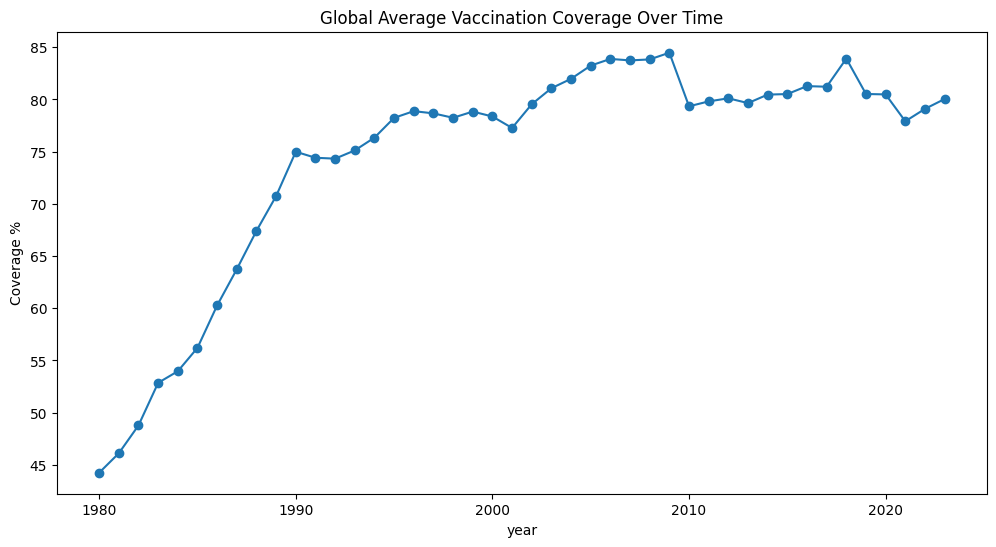

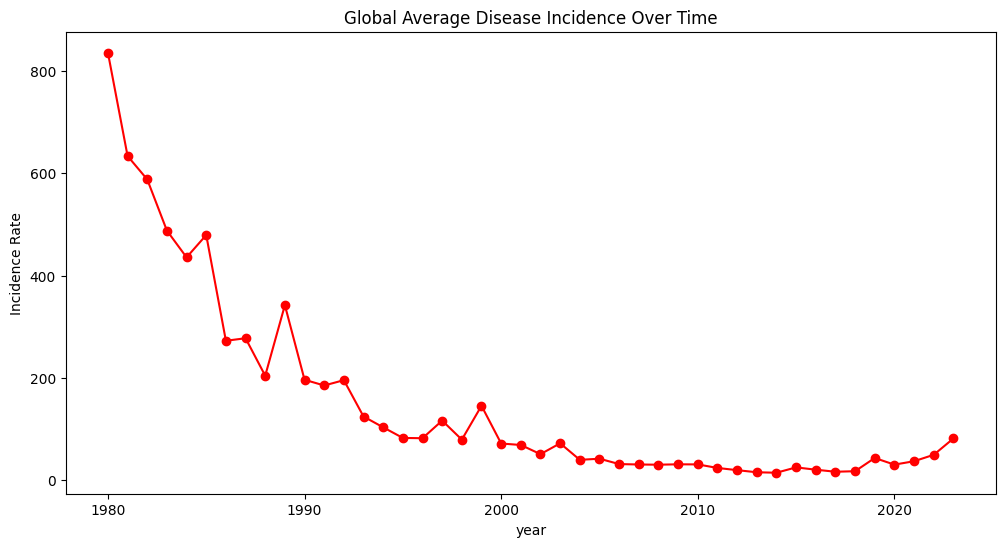

/tmp/ipython-input-3542486677.py:82: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


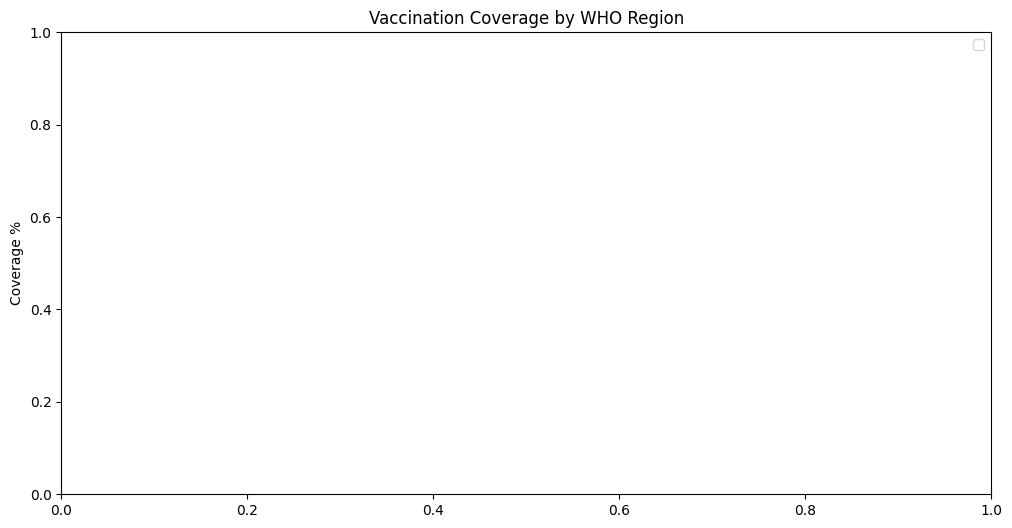


Correlation between coverage % and incidence rate:
                  coverage_percent  incidence_rate
coverage_percent          1.000000       -0.014466
incidence_rate           -0.014466        1.000000


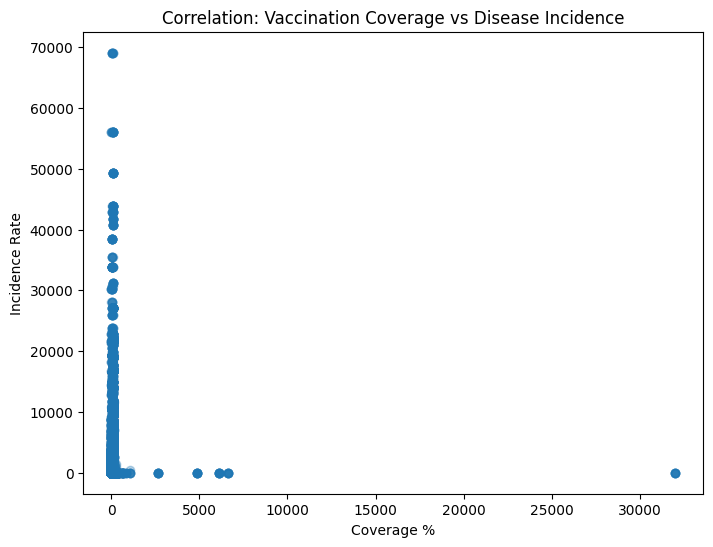

In [ ]:
# Exploratory Data Analysis (EDA)
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Connect to the Database ---
db_path = "/content/vaccination_data.db"  # adjust path if needed
conn = sqlite3.connect(db_path)

# --- 2. Load Key Fact Tables with Joins ---
# Vaccination coverage with country + vaccine + year
coverage_df = pd.read_sql("""
SELECT c.country_name, v.vaccine_name, y.year, f.coverage_percent
FROM fact_coverage f
JOIN dim_countries c ON f.country_id = c.country_id
JOIN dim_vaccines v ON f.vaccine_id = v.vaccine_id
JOIN dim_years y ON f.year_id = y.year_id
""", conn)

# Disease incidence with country + disease + year
incidence_df = pd.read_sql("""
SELECT c.country_name, d.disease_name, y.year, f.incidence_rate
FROM fact_incidence f
JOIN dim_countries c ON f.country_id = c.country_id
JOIN dim_diseases d ON f.disease_id = d.disease_id
JOIN dim_years y ON f.year_id = y.year_id
""", conn)

# Reported cases
cases_df = pd.read_sql("""
SELECT c.country_name, d.disease_name, y.year, f.cases
FROM fact_cases f
JOIN dim_countries c ON f.country_id = c.country_id
JOIN dim_diseases d ON f.disease_id = d.disease_id
JOIN dim_years y ON f.year_id = y.year_id
""", conn)

print(" Data loaded for EDA")
print("Coverage:", coverage_df.shape, "Incidence:", incidence_df.shape, "Cases:", cases_df.shape)


# --- 3. Statistical Summaries ---
print("\n--- Vaccination Coverage Summary ---")
print(coverage_df["coverage_percent"].describe())

print("\n--- Disease Incidence Summary ---")
print(incidence_df["incidence_rate"].describe())

print("\n--- Reported Cases Summary ---")
print(cases_df["cases"].describe())


# --- 4. Visualization: Coverage Trends ---
plt.figure(figsize=(12,6))
coverage_trends = coverage_df.groupby("year")["coverage_percent"].mean()
coverage_trends.plot(kind="line", marker="o", title="Global Average Vaccination Coverage Over Time")
plt.ylabel("Coverage %")
plt.show()

# --- 5. Visualization: Disease Incidence Trends ---
plt.figure(figsize=(12,6))
incidence_trends = incidence_df.groupby("year")["incidence_rate"].mean()
incidence_trends.plot(kind="line", marker="o", color="red", title="Global Average Disease Incidence Over Time")
plt.ylabel("Incidence Rate")
plt.show()

# --- 6. Regional Disparities ---
regional_cov = pd.read_sql("""
SELECT c.who_region, y.year, AVG(f.coverage_percent) as avg_coverage
FROM fact_coverage f
JOIN dim_countries c ON f.country_id = c.country_id
JOIN dim_years y ON f.year_id = y.year_id
GROUP BY c.who_region, y.year
""", conn)

plt.figure(figsize=(12,6))
for region, group in regional_cov.groupby("who_region"):
    plt.plot(group["year"], group["avg_coverage"], marker="o", label=region)

plt.title("Vaccination Coverage by WHO Region")
plt.ylabel("Coverage %")
plt.legend()
plt.show()

# --- 7. Correlation Analysis (Coverage vs Incidence) ---
merged_df = pd.read_sql("""
SELECT c.country_name, y.year, v.vaccine_name, d.disease_name,
       cov.coverage_percent, inc.incidence_rate
FROM fact_coverage cov
JOIN dim_countries c ON cov.country_id = c.country_id
JOIN dim_vaccines v ON cov.vaccine_id = v.vaccine_id
JOIN dim_years y ON cov.year_id = y.year_id
JOIN fact_incidence inc ON inc.country_id = c.country_id AND inc.year_id = y.year_id
JOIN dim_diseases d ON inc.disease_id = d.disease_id
""", conn)

print("\nCorrelation between coverage % and incidence rate:")
print(merged_df[["coverage_percent","incidence_rate"]].corr())

plt.figure(figsize=(8,6))
plt.scatter(merged_df["coverage_percent"], merged_df["incidence_rate"], alpha=0.3)
plt.title("Correlation: Vaccination Coverage vs Disease Incidence")
plt.xlabel("Coverage %")
plt.ylabel("Incidence Rate")
plt.show()
